# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# Imports
# plots
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')

# data
import numpy as np
import pandas as pd
import re

# graph
import networkx as nx
from networkx.drawing.nx_agraph import read_dot


In [2]:

# helper methods
from utils import get_nodes, get_skill_id_ranks, choose_ranking, find_user_subtasks, calculate_mastery_level, find_word_in_list, get_random_ids, convert_to_csv, load_from_csv

In [3]:
# Import the tables of the data set as dataframes.

DATA_DIR = './data' # You many change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

## Task 0: Research Question

**Research question:**
* What factors influence the process of learning?  

* Which tasks should be solved to obtain the fastest progress? Is there any tasks of this kind? 

* How in task-based learning we can assume that the student is learnt. Is the time most important? How many correct answers? 

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [3]:
# In subtasks dataset exist more event_id than in events dataset
print(f'How many events in dataset: {len(events)}')
print(f'How many subtasks in dataset: {len(subtasks)}')
subtasks = subtasks[subtasks.event_id < len(events)]

How many events in dataset: 34094
How many subtasks in dataset: 55047


### Skill graph
We decide to base calculation of the mastery in games on skill graph, which we are downloading below.

In [4]:
# Read the DOT file and store it as a NetworkX graph
dot_file_path = 'data/04_calcularis_skill_map_dot_file.dot'
G = read_dot(dot_file_path)

In [5]:
# Draw graph of skills
def draw_graph(G):
    plt.figure(figsize=(40, 80))
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    node_sizes = [len(G.adj[node]) * 100 for node in G.nodes]
    edge_widths = [1 + len(G.get_edge_data(u, v)) for u, v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.5)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3, arrowsize=10, arrowstyle='->')
    labels = {node: node.replace('\n', ' ') for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    plt.axis('off')
    plt.savefig('skill_graph')
    plt.close()

draw_graph(G)

![myfig](skill_map.png)

### Dataframe with mastery levels
At the beginning, we are looking for the games titles in skill map, which fits with game name and skill id found in the dataframe. Then we have to find ancestors of the each game, based on position in the skill map. Thanks to this we can calculate the mastery skill over all games that contributes to development of each skill for all the users.

To calculate mastery level we are using methods from utils.py. They are described in comments.

Finally we stored created dataframe in dataframe.csv file

In [11]:
# Create dataframe with multindex [user_id, week, game]
def create_dataframe_multi_index(G, how_many=100, verbose=False):

    # Create empty dataframe
    multi_index = [[], [], []]
    df = pd.DataFrame(columns = ['mastery_level', 'mastery_level_diff'], index = multi_index)
    df.index = df.index.set_names(['user_id', 'game_name', 'week'])

    subtasks_events = subtasks.merge(events, on='event_id')

    for user_id, user in users.iterrows(): 
        # Find user_subtasks 
        user_subtasks = find_user_subtasks(subtasks_events, user_id)[['week_number', 'game_name', 'skill_id', 'correct']]
        
        # Create index for the user:
        # Get unique games names
        game_names = events.loc[subtasks['event_id']]['game_name'].unique()

        # Get unique weeks
        unique_weeks = user_subtasks['week_number'].unique()

        len_weeks = len(unique_weeks)
        len_game_names = len(game_names)

        user_ids = [user_id for i in range(len_weeks * len_game_names)]

        user_unique_weeks = user_subtasks['week_number'].unique()
        user_unique_weeks = np.concatenate([user_unique_weeks]* (len_game_names))

        user_unique_games = [game for game in game_names for week in range(len_weeks)]

        tuples = list(zip(user_ids, user_unique_games, user_unique_weeks))

        # Assign index values
        index = pd.MultiIndex.from_tuples(tuples, names=['user_id', 'game_name', 'week'])
        user_df = pd.DataFrame(columns = ['mastery_level', 'mastery_level_diff'], index = index)

        # Calculate mastery level
        mastery_level = []
        for game in game_names:
            for week in unique_weeks:
                # Find info about statistics of the user for the game for the week
                associated_events = user_subtasks[(user_subtasks['game_name'] == game) & (user_subtasks['week_number'] == week)]
                
                # If the user played the game during the week
                if not associated_events.empty:
                    mean_skill = associated_events['skill_id'].mean()
                    lv = calculate_mastery_level(G, user_subtasks, week, game, mean_skill)
                    mastery_level.append(lv)
                # If the user did not play the game during the week, but we can get previous statictics
                elif week > unique_weeks[0]:
                    mastery_level.append(mastery_level[-1])
                # If the week == 1 and player did not play the game
                else: 
                    mastery_level.append(0.0)
                

        # Assign mastery levls
        mastery_level = pd.DataFrame(mastery_level, columns = ['mastery_level'])
        mastery_level.index = index
        user_df['mastery_level'] = mastery_level

        # Assign the difference of mastery lvls
        user_df['mastery_level_diff'] = user_df['mastery_level'].diff()
        user_df.loc[user_df.index.get_level_values('week') == 1, 'mastery_level_diff'] = 0.0

        # Add stats of the user to the dataframe
        df = pd.concat([df, user_df], axis=0)

        # Display info
        if user_id % 10 == 0 and verbose:
            print(f'**** processing data for user id == {user_id} ****')
        # Calculate for fraction of all users
        if user_id > how_many:
            break
    return df

df = create_dataframe_multi_index(G, len(users), True)
convert_to_csv(df, 'dataframe.csv')

**** processing data for user id == 10 ****
**** processing data for user id == 20 ****
**** processing data for user id == 30 ****
**** processing data for user id == 40 ****
**** processing data for user id == 50 ****
**** processing data for user id == 60 ****
**** processing data for user id == 70 ****
**** processing data for user id == 80 ****
**** processing data for user id == 90 ****
**** processing data for user id == 100 ****
**** processing data for user id == 110 ****
**** processing data for user id == 120 ****
**** processing data for user id == 130 ****
**** processing data for user id == 140 ****
**** processing data for user id == 150 ****
**** processing data for user id == 160 ****
**** processing data for user id == 170 ****
**** processing data for user id == 180 ****
**** processing data for user id == 190 ****
**** processing data for user id == 200 ****
**** processing data for user id == 210 ****
**** processing data for user id == 220 ****
**** processing dat

In [6]:
df = load_from_csv('dataframe.csv')
df.head()

mastery_level  mastery_level_diff
user_id game_name  week                                   
1       Subitizing 1               1.0                 0.0
                   2               1.0                 0.0
                   3               1.0                 0.0
                   4               1.0                 0.0
                   5               1.0                 0.0

### Display results
We are creating two graphs, each of them showing one column in our dataframe for 10 users for chosen game. 
- mastery_level: it is representation of development of skill over time
- mastery_level_diff: it represents the progress between each week over time

In [13]:
# Display mastery levels
def show_mastery_details(df, users, game, col):
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, user in enumerate(users):
        temp_df = df.sort_index().loc[(user, game), :]
        ax.plot(temp_df.index, temp_df[col], label=f'{user}')

    ax.set_title(f'{col} of {game} Over Time')
    ax.set_xlabel('Weeks')
    ax.set_ylabel(col)
    ax.legend(title='User ID', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.savefig(f'{col}.png')
    plt.close()

random_user_ids = get_random_ids(df, 10, 'Subitizing', 'mastery_level_diff')
show_mastery_details(df, random_user_ids, 'Subitizing', 'mastery_level')

#random_user_ids = get_random_ids(df, 10, 'Subitizing', 'mastery_level_diff')
show_mastery_details(df, random_user_ids, 'Subitizing', 'mastery_level_diff')

a
1
0.0
2
-0.8985507246376812
3
0.0
4
0.0
5
0.0
6
0.0
8
0.0
9
0.0
10
0.0
12
0.0
13
0.0
14
0.0
15
0.0
16
0.0
17
0.0
19
0.0
20
0.0
21
0.0
24
0.0
25
0.0
26
0.0
27
0.0
28
0.0
29
0.0
30
0.0
31
0.0
34
0.09999999999999998
35
0.0
37
0.0
38
0.0
39
0.10714285714285715
40
0.0
41
0.0
44
0.0
45
0.0
46
0.0
47
0.0
48
0.0
49
-0.44339622641509435
50
0.0
51
0.0
52
0.0
53
0.0
54
0.0
55
-0.35714285714285715
56
0.0
57
0.0
58
0.0
60
0.0
61
0.03636363636363636
62
0.0
63
0.0
64
0.0
65
-0.16666666666666669
66
0.0
67
0.0
68
0.0
69
0.0
70
0.0
71
0.0
72
0.0
75
0.0
76
-0.4811320754716981
77
0.0
79
-0.25
80
-0.9147286821705427
81
0.0
82
0.0
84
0.0
86
0.0
87
0.0
88
0.0
89
0.0
90
0.0
91
0.0
92
0.0
93
0.0
94
0.0
95
0.0
98
0.0
99
0.0
100
0.0
101
-0.7142857142857143
102
0.0
103
0.0
105
0.0
106
0.0
108
0.0
109
0.0
110
0.0
112
0.0
113
0.0
114
0.0
115
0.0
116
0.0
117
0.0
120
0.0
124
0.0
125
-0.35064935064935066
126
0.0
127
0.0
128
0.0
129
0.0
131
0.0
132
0.0
133
0.0
134
-0.7894736842105263
135
0.0
136
0.0
137
0.0
138
0.0
1

c:\Users\ewa.miazga\OneDrive - Politechnika Warszawska\Pulpit\studies\SEM 4\MLFBD\milestone-4-calcularis-crusaders\project\milestone-04\utils.py:105: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(df.loc[(user, game), col].sum())
c:\Users\ewa.miazga\OneDrive - Politechnika Warszawska\Pulpit\studies\SEM 4\MLFBD\milestone-4-calcularis-crusaders\project\milestone-04\utils.py:106: PerformanceWarning: indexing past lexsort depth may impact performance.
  if float(df.loc[(user, game), col].sum()) != 0.0:


452
0.0
453
0.0
454
0.0
455
0.0
456
0.0
457
0.0
458
0.0
459
0.0
460
0.0
461
0.0
462
0.0
464
0.0
466
0.0
468
0.0
469
0.0
470
0.0
471
0.0
472
0.0
473
0.0
475
-0.39
476
0.0
477
0.0
478
-0.33333333333333337
479
0.0
481
0.0
482
0.0
485
0.0
486
0.0
489
0.0
490
0.0
492
0.0
493
0.0
495
0.0
496
0.0
497
0.0
498
0.0
499
0.0
500
0.0
501
0.0
502
0.0
503
0.0
505
-0.9583333333333333
507
0.0
508
0.0
509
0.0
510
0.0
511
0.30000000000000004
512
0.0
513
0.0
514
0.0
516
0.0
517
0.0
518
0.0
520
-0.125
522
0.0
523
0.0
526
0.0
527
0.0
528
0.0
529
0.0
531
0.0
532
0.0
533
0.0
536
0.0
537
0.0
538
0.0
539
0.0
540
0.0
541
0.0
543
0.0
544
0.0
545
0.0
547
0.0
548
0.0
549
0.0
551
0.0
552
0.0
553
0.0
554
0.0
555
0.0
557
0.0
558
0.0
560
0.0
561
0.0
563
0.0
565
0.0
566
0.0
567
0.0
568
0.0
569
0.0
570
0.0
571
0.0
573
-0.25
574
0.0
575
-0.25
576
0.25
577
0.0
578
0.0
579
0.0
580
0.0
581
0.0
582
0.0
583
0.0
585
-0.5714285714285714
587
0.0
589
0.0
591
0.0
592
0.0
594
0.0
595
0.0
596
0.0
597
-0.12943432406519653
598
0.0
599


*Your discussion about your processing decisions goes here*

#### mastery level
We can track the progress or regress of developing of the skill, what is important not many users achieve the mastery level above 0.5 at the end of their learning, so it may mean that they drop the learning process because of some reasons, which could be boredom or lack of motivation to continue.

![mastery_level](mastery_level.png)

#### mastery level differences
What is of much significance, most of users are not making progress during all the period of research. They only play the game in some of the weeks, where in others they are not progressing at all. This could provide us some insights why they are not making great progess which can be observed in first plot. Also the differences between mastery levels over weeks are not better than 0.1, usually they are below zero. The ratio between how much of them making progress and regress is small, according to the fact most of differences are negative.

![mastery_level_diff](mastery_level_diff.png)

We can conclude that the values of this column and patterns that can be found in this graphs are completely different. These will be used to check which allows us to produce better predictions, as the first one might be misinterpreted by our model, because even though player is not playing the game his mastery skill is maintained.


## Task 2: Model Building

Train a model for your research question. 

### Training baseline model: BKT

In [88]:
# Loading preprocessed dataframe generated in experiment.ipynb
# Unamed:0 is the index column of the dataframe before preprocessing (many rows where removed)
df_task_events = pd.read_csv('data/calcularis_small_task_events.csv')
df_task_events.rename(columns={'game_name': 'skill_name'}, inplace=True)
df_task_events.head()

,Unnamed: 0,event_id,user_id,mode_event,skill_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,correct,level_2,cumulative_percent_correct
0,0,118,7,NORMAL,Subitizing,R10,1.00000,ConciseTimeoutDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,135,1.00000
1,1,118,7,NORMAL,Subitizing,R10,1.00000,ConciseSubitizingTaskDescription,2015-03-19 18:48:57.303000+00:00,2015,12,4,0,True,134,1.00000
2,2,119,7,NORMAL,Conversion,R10,3.00000,ConciseConversionTaskDescription,2015-03-20 18:07:17.288000+00:00,2015,12,5,0,True,136,1.00000
3,3,120,7,NORMAL,Landing,R10,19.00000,ConciseLandingTaskDescription,2015-03-23 15:18:26.515000+00:00,2015,13,1,1,True,137,1.00000
4,4,121,7,END_OF_NR,Conversion,R10,7.00000,ConciseConversionTaskDescription,2015-04-02 14:03:06.836000+00:00,2015,14,4,2,True,138,1.00000


In [94]:
# Creating the first model with default parameters and fitting it for all games
model = Model(seed=0)
model.fit(data=df_task_events, forgets=False)
model.evaluate(data=df_task_events, metric='auc') 

0.7765331719667002

In [100]:
# Vizualizing parameters
model.params().head(10)

value
skill      param   class          
Subitizing prior   default 0.66811
           learns  default 0.05285
           guesses default 0.45480
           slips   default 0.20789
           forgets default 0.00000
Conversion prior   default 0.89709
           learns  default 0.03963
           guesses default 0.62210
           slips   default 0.10360
           forgets default 0.00000

In [131]:
# Predicting mastery level for all users
# state_predictions: score between 0 and 1 that measures the extent to which the student has mastered that skill, after that question
# correct_predictions: score between 0 and 1 that measures the extent to which the model thinks that the student will answer correctly to that question
df_preds = model.predict(data=df_task_events)
df_preds[df_preds['skill_name']=='Conversion'][['user_id', 'correct', 'correct_predictions', 'state_predictions']].head()

,user_id,correct,correct_predictions,state_predictions
50952,1,1,0.86817,0.89709
51366,1,1,0.87698,0.92918
52090,1,1,0.88317,0.95175
52365,1,0,0.88745,0.96736
48376,2,0,0.86817,0.89709


In [97]:
# Creating the second model with forgets=True and fitting it for all games
model_forgets = Model(seed=0)
model_forgets.fit(data=df_task_events, forgets=True)
model_forgets.evaluate(data=df_task_events, metric='auc')

0.7830957178701483

In [99]:
# Vizualizing parameters
model_forgets.params().head(10)

value
skill      param   class          
Subitizing prior   default 0.80480
           learns  default 0.35636
           guesses default 0.25194
           slips   default 0.21333
           forgets default 0.06911
Conversion prior   default 0.84631
           learns  default 0.29306
           guesses default 0.54626
           slips   default 0.08488
           forgets default 0.02918

In [132]:
# Predicting mastery level for all users
df_preds_forgets = model_forgets.predict(data=df_task_events)
df_preds_forgets[df_preds_forgets['skill_name']=='Landing'][['user_id', 'correct', 'correct_predictions', 'state_predictions']].head()

,user_id,correct,correct_predictions,state_predictions
51742,1,0,0.37399,0.36995
53936,1,1,0.47541,0.55869
54302,1,1,0.59904,0.78873
54907,1,1,0.61771,0.82348
49587,2,0,0.37399,0.36995


In [106]:
df_preds.head()

,Unnamed: 0,event_id,user_id,mode_event,skill_name,number_range,skill_id,type_subtask,date,Year,Week,Day,week_sequential,correct,level_2,cumulative_percent_correct,correct_predictions,state_predictions
50463,54328,0,1,NORMAL,Subitizing,R10,1.00000,ConciseSubitizingTaskDescription,2022-11-02 08:39:12.355000+00:00,2022,44,3,0,1,0,1.00000,0.68229,0.80480
50464,54329,0,1,NORMAL,Subitizing,R10,1.00000,ConciseTimeoutDescription,2022-11-02 08:39:12.355000+00:00,2022,44,3,0,1,1,1.00000,0.72757,0.88948
50952,54340,1,1,NORMAL,Conversion,R10,4.00000,ConciseConversionTaskDescription,2022-11-11 10:26:27.893000+00:00,2022,45,5,1,1,2,1.00000,0.85843,0.84631
51366,54331,2,1,NORMAL,Conversion,R10,7.00000,ConciseConversionTaskDescription,2022-11-18 10:34:01.044000+00:00,2022,46,5,2,1,3,1.00000,0.87991,0.90453
51742,54330,3,1,NORMAL,Landing,R10,19.00000,ConciseLandingTaskDescription,2022-11-25 10:32:43.428000+00:00,2022,47,5,3,0,4,0.00000,0.37399,0.36995


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting the learning rate per skill
# Plotting the mastery level for a random user



### Training an LGBM model

In [119]:
import importlib
importlib.reload(utils_lgbm)

<module 'utils_lgbm' from '/home/milestone-4-calcularis-crusaders/project/milestone-04/utils_lgbm.py'>

In [124]:
import utils_lgbm
import lightgbm as lgb


In [61]:
mastery_df = load_from_csv('dataframe.csv').reset_index()
full_df = utils_lgbm.create_timeseries(events, subtasks)

In [109]:
index = ['event_id','user_id']
cat_features = ['mode_event', 'game_name','number_range','skill_id', 'type_subtask']
cat_features_withnulls = [ 'destination', 'multiplier','operator','representation', 'solutionRepresentation', 'solveMode']
date_features = ['date','Year', 'Week', 'Day','week']
target_feature = ['correct']

In [63]:
full_df = full_df[index + cat_features + date_features + target_feature]

In [95]:
df = full_df.merge(mastery_df, how='left', on=['week','user_id','game_name'])

In [96]:
df = df[~ df['mastery_level'].isna()]

In [97]:
df.isna().sum()

event_id              0
user_id               0
mode_event            0
game_name             0
number_range          0
skill_id              0
type_subtask          0
date                  0
Year                  0
Week                  0
Day                   0
week                  0
correct               0
mastery_level         0
mastery_level_diff    0
dtype: int64

In [98]:
# LGBM only accepts int, bool and float
for col in cat_features:
    # Convert categories into ints
    df[col] = df[col].astype('category')
df['week'] = df['week'].astype('int32')
df[target_feature] = df[target_feature].astype('bool')

In [144]:
generated_features = []
features = index + cat_features + generated_features + ['week']
target_feature = ['mastery_level'] # or 'mastery_level_diff'

lgb_train, lgb_eval, lgb_test = utils_lgbm.create_train_test_split(df, features, target_feature, cat_features)

In [145]:
model = utils_lgbm.train_model(lgb_train, lgb_eval)

/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1

[LightGBM] [Info] Number of positive: 23345, number of negative: 1516
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 24861, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.939021 -> initscore=2.734308
[LightGBM] [Info] Start training from score 2.734308
Training until validation scores don't improve for 8 rounds


/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[6]	training's auc: 0.930839	valid_1's auc: 0.881826


In [146]:
overall_auc = model.eval(lgb_test, 'auc')
print(f"Overall AUC for test data is {overall_auc[0][2]}")

Overall AUC for test data is 0.8794627625063423


/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/my_venvs/mlbd-project/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


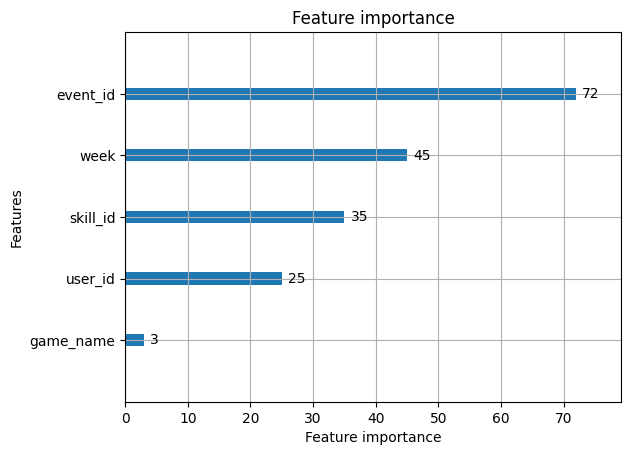

In [147]:
lgb.plot_importance(model)
plt.show()

In [148]:
import shap

In [151]:
test = df.query('user_id >= 800')[features]

In [152]:
%time shap_values = shap.TreeExplainer(model).shap_values(test)


CPU times: user 720 ms, sys: 28.6 ms, total: 749 ms
Wall time: 328 ms


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


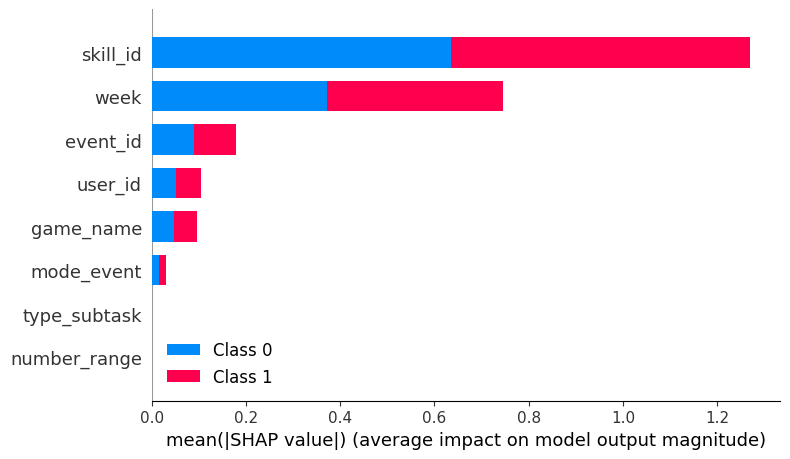

In [153]:
shap.summary_plot(shap_values, test)


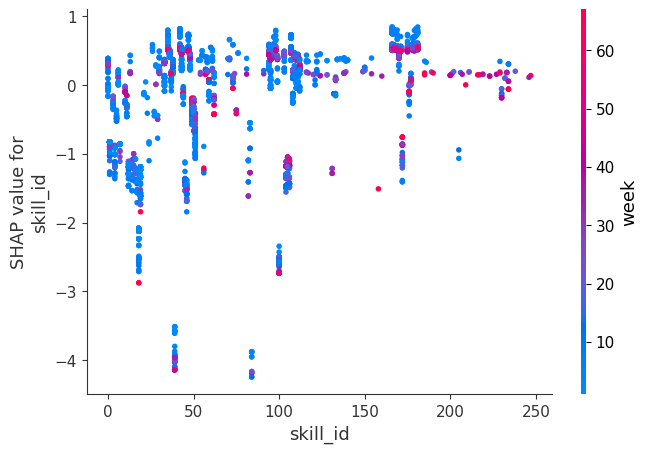

In [155]:
shap.dependence_plot("skill_id", shap_values[1], test)


## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*